In [7]:
# Cell 1: imports and path setup

import os
import sys
import math
import requests
import matplotlib.pyplot as plt
from pathlib import Path

# Figure out repo root:
# If we're in SERO/notebooks, go up to SERO; otherwise assume cwd is the root.
cwd = Path.cwd()
if cwd.name == "notebooks":
    repo_root = cwd.parent
else:
    repo_root = cwd

backend_path = repo_root / "backend"

print("CWD       :", cwd)
print("repo_root :", repo_root)
print("backend   :", backend_path, "exists:", backend_path.is_dir())

# Add backend directory to sys.path so `app` is importable
if str(backend_path) not in sys.path:
    sys.path.append(str(backend_path))

# >>> IMPORTANT: no leading `..` here <<<
from app.services.optimizer import optimize_staging

CWD       : c:\Users\jason\VSProjects\SERO\notebooks
repo_root : c:\Users\jason\VSProjects\SERO
backend   : c:\Users\jason\VSProjects\SERO\backend exists: True


In [16]:
# Cell 2: fetch risk snapshot from backend

RISK_URL = "http://localhost:8000/risk/latest"  # change port if needed

resp = requests.get(RISK_URL)
resp.raise_for_status()

risk_snapshot = resp.json()

# /risk/latest currently returns a *list* of cells, not {"cells": [...]}.
# But let's be robust and handle both shapes.
if isinstance(risk_snapshot, dict) and "cells" in risk_snapshot:
    cells = risk_snapshot["cells"]
    timestamp = risk_snapshot.get("timestamp")
else:
    # what you showed: a plain list of cell dicts
    cells = risk_snapshot
    timestamp = max(c["bucket_start"] for c in cells)
    print("Derived timestamp:", timestamp)
print(f"Got {len(cells)} cells")
print("Example cell:", cells[0])


Derived timestamp: 2025-11-18T12:00:00+00:00
Got 137 cells
Example cell: {'cell_id': 42, 'bucket_start': '2025-11-18T12:00:00+00:00', 'risk_score': 0.2200629562139511, 'high_risk': False, 'expected_incidents': 0.0273952167481184, 'fire_last_1h': 0.0, 'fire_last_3h': 0.0, 'fire_last_24h': 1.0, 'police_last_1h': 0.0, 'police_last_3h': 0.0, 'police_last_24h': 0.0, 'lat': 47.495, 'lon': -122.265}


In [24]:
# Cell 3: define demo stations spread across the risk area

lat_min = min(c["lat"] for c in cells)
lat_max = max(c["lat"] for c in cells)
lon_min = min(c["lon"] for c in cells)
lon_max = max(c["lon"] for c in cells)

lat_span = lat_max - lat_min
lon_span = lon_max - lon_min

# 5 stations: SW, SE, NW, NE, and center
stations = [
    {
        "station_id": "FS1",  # SW
        "lat": lat_min + 0.2 * lat_span,
        "lon": lon_min + 0.2 * lon_span,
        "vehicles_current": 3,
    },
    {
        "station_id": "FS2",  # SE
        "lat": lat_min + 0.2 * lat_span,
        "lon": lon_min + 0.8 * lon_span,
        "vehicles_current": 3,
    },
    {
        "station_id": "FS3",  # NW
        "lat": lat_min + 0.8 * lat_span,
        "lon": lon_min + 0.2 * lon_span,
        "vehicles_current": 2,
    },
    {
        "station_id": "FS4",  # NE
        "lat": lat_min + 0.8 * lat_span,
        "lon": lon_min + 0.8 * lon_span,
        "vehicles_current": 2,
    },
    {
        "station_id": "FS5",  # center
        "lat": lat_min + 0.5 * lat_span,
        "lon": lon_min + 0.5 * lon_span,
        "vehicles_current": 4,
    },
]

total_vehicles = sum(s["vehicles_current"] for s in stations)
print(f"Total vehicles: {total_vehicles}")
stations


Total vehicles: 14


[{'station_id': 'FS1', 'lat': 47.543, 'lon': -122.375, 'vehicles_current': 3},
 {'station_id': 'FS2',
  'lat': 47.543,
  'lon': -122.28500000000001,
  'vehicles_current': 3},
 {'station_id': 'FS3', 'lat': 47.687, 'lon': -122.375, 'vehicles_current': 2},
 {'station_id': 'FS4',
  'lat': 47.687,
  'lon': -122.28500000000001,
  'vehicles_current': 2},
 {'station_id': 'FS5',
  'lat': 47.614999999999995,
  'lon': -122.33000000000001,
  'vehicles_current': 4}]

In [25]:
# Cell 4: run the optimizer

result = optimize_staging(cells=cells, stations=stations)

stations_out = result["stations"]
moves = result["moves"]
total_cost = result["total_travel_cost"]

print("=== Station targets ===")
for s in stations_out:
    print(
        f"{s['station_id']}: current={s['vehicles_current']}, "
        f"target={s['vehicles_target']}, local_risk={s['local_risk']:.3f}"
    )

print("\n=== Moves ===")
for m in moves:
    print(
        f"{m['num_vehicles']} vehicles: {m['from_station_id']} -> {m['to_station_id']} "
        f"(distance={m['distance']:.4f})"
    )

print(f"\nTotal travel cost: {total_cost:.4f}")

=== Station targets ===
FS1: current=3, target=1, local_risk=5.057
FS2: current=3, target=1, local_risk=2.652
FS3: current=2, target=3, local_risk=11.123
FS4: current=2, target=2, local_risk=5.637
FS5: current=4, target=7, local_risk=21.741

=== Moves ===
1 vehicles: FS1 -> FS3 (distance=0.1440)
1 vehicles: FS1 -> FS5 (distance=0.0849)
2 vehicles: FS2 -> FS5 (distance=0.0849)

Total travel cost: 0.3987


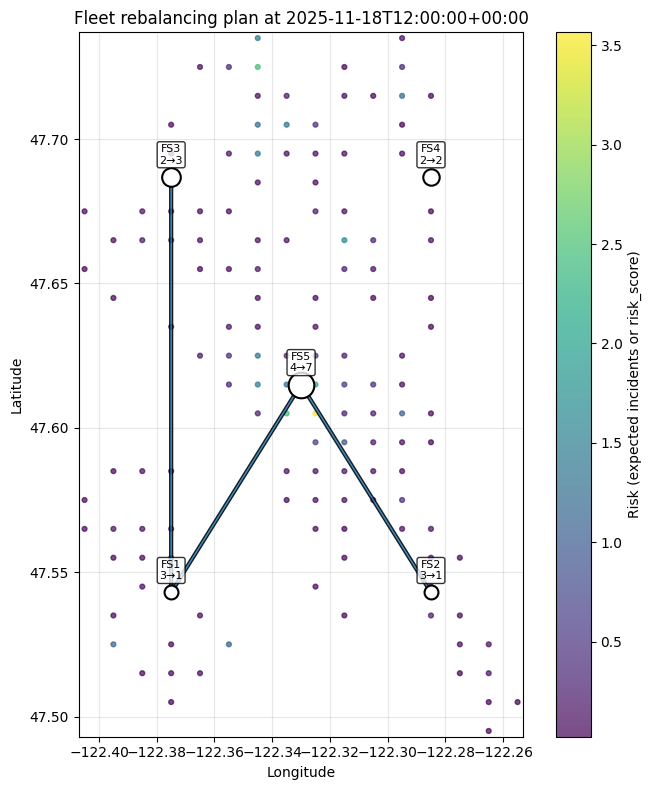

In [26]:
# Cell 5: visualize risk grid, stations, and rebalancing moves (improved)

# 1) Extract risk for plotting (prefer expected_incidents, fallback to risk_score)
lats = [c["lat"] for c in cells]
lons = [c["lon"] for c in cells]
risks = [
    c.get("expected_incidents", c.get("risk_score", c.get("risk", 0.0)))
    for c in cells
]

lat_min = min(lats)
lat_max = max(lats)
lon_min = min(lons)
lon_max = max(lons)

plt.figure(figsize=(7, 8))

# Risk scatter (background)
sc = plt.scatter(lons, lats, c=risks, s=12, alpha=0.7, zorder=1)
cbar = plt.colorbar(sc)
cbar.set_label("Risk (expected incidents or risk_score)")

# 2) Plot stations with marker size proportional to target vehicles
for s in stations_out:
    lon = s["lon"]
    lat = s["lat"]
    cur = s["vehicles_current"]
    tgt = s["vehicles_target"]

    size = 60 + 40 * tgt  # bigger, clearer

    # Station marker
    plt.scatter(
        lon,
        lat,
        s=size,
        edgecolors="black",
        facecolors="white",
        linewidths=1.5,
        zorder=3,
    )

    # Offset label above marker with a white box
    label = f"{s['station_id']}\n{cur}→{tgt}"
    plt.annotate(
        label,
        xy=(lon, lat),
        xytext=(0, 8),  # offset in points
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=8,
        bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8),
        zorder=4,
    )

# Helper to find station by id
def find_station(station_id: str):
    for s in stations_out:
        if s["station_id"] == station_id:
            return s
    raise KeyError(station_id)

# 3) Draw arrows for moves (under labels but above heatmap)
for m in moves:
    s_from = find_station(m["from_station_id"])
    s_to = find_station(m["to_station_id"])

    x0, y0 = s_from["lon"], s_from["lat"]
    x1, y1 = s_to["lon"], s_to["lat"]
    dx = x1 - x0
    dy = y1 - y0

    plt.arrow(
        x0,
        y0,
        dx,
        dy,
        length_includes_head=True,
        head_width=0.0015,
        head_length=0.0015,
        alpha=0.85,
        linewidth=1.0,
        zorder=2,
    )

# 4) Axes formatting
plt.xlim(lon_min - 0.002, lon_max + 0.002)
plt.ylim(lat_min - 0.002, lat_max + 0.002)

plt.xlabel("Longitude")
plt.ylabel("Latitude")

title = "Fleet rebalancing plan"
if "timestamp" in globals() and timestamp is not None:
    title += f" at {timestamp}"
plt.title(title)

# Format ticks nicely
plt.gca().set_aspect("equal", adjustable="box")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


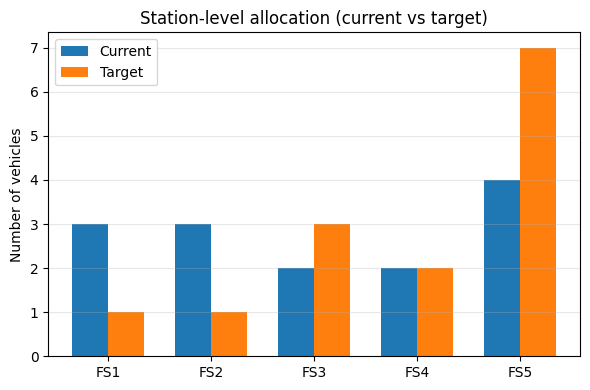

In [ ]:
# Cell 6: bar chart of current vs target vehicles per station

import numpy as np

names = [s["station_id"] for s in stations_out]
cur = np.array([s["vehicles_current"] for s in stations_out])
tgt = np.array([s["vehicles_target"] for s in stations_out])

x = np.arange(len(names))
width = 0.35

plt.figure(figsize=(6, 4))
plt.bar(x - width/2, cur, width, label="Current")
plt.bar(x + width/2, tgt, width, label="Target")

plt.xticks(x, names)
plt.ylabel("Number of vehicles")
plt.title("Station-level allocation (current vs target)")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()